# Space Growth Winners

This notebook imports OD600 data from each of the three ground plates
and three space plates and writes plots and tables pertaining to the
three space-based contests (Best Huddle, Best Tipoff, Best Sprint). It
also writes the plots and tables comparing the growth results of the
experiments aboard the Space Station to those conducted at UC Davis.

I regret that, although functional, this some of the worst code I've 
ever written. I beg forgiveness on the grounds that SpectraMax file format
is mind-bendingly stupid. Also, we re-designed the project and switched 
goals and deadlines frequently as we adapted to launch window delay and 
conflicting information about the capabilities of the SpectraMax device 
aboard the International Space Station. I had considered re-writing it now
that the project is complete, but in the interests of full disclosure, I
decided to preserve it in its original form. This is a citizen science
project, and I felt it was more impotant for the public to see how things 
were actually done. All that I've done is added comments where things are
particularly confusing or stupid.

In [15]:
import numpy
import csv
import copy

# Contrary to all reason, when you read multiple points in each well
# with a SpecraMax plate reader, it proceeds as follows :
#
#     for each point
#         for each row
#             for each column
#                 for each replicate
#                     read OD600
#                 average replicates
#
# This maximizes the time it takes to complete a read cycle. It *should*
# read all nine points before moving on to the next well, there's no way
# to make it do that. There's also no way to make it read more than a 3x3
# grid, which is also unfortunate, though given the way it orders these
# operations, it's not surprising. The file format it writes reflects this
# bizarre design choice.

# This is the whitespace that marks the boundary between blocks of reads
stupid_delimeter = '\t\t\n\t\t\n'
stop_at = 273 # in case the run was not completed, stop here
#stupid_delimeter = '\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\n'

# import species metadata and plate map
spacebugs = []
with open('spacebugsnames_2.txt', 'rb') as csvfile :
    csvreader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for row in csvreader:
        spacebugs.append( { 'source'   : row[1], 
                            'species'  : row[2], 
                            'name'     : row[3],
                            'longname' : row[4],
                            'alive'    : False,
                            'alpha'    : 0,
                            'N0'       : 0,
                            'Hsat'     : 0,
                            'huddle'   : 0,
                            'huddle_d' : '',
                            'tipoff'   : 0,
                            'tipoff_d' : '',
                            'sprint'   : 0,
                            'sprint_d' : '',
                            'data_1_1' : [], 
                            'data_1_2' : [], 
                            'data_2_1' : [], 
                            'data_2_2' : [], 
                            'data_3_1' : [], 
                            'data_3_2' : [] } )

groundbugs = copy.deepcopy(spacebugs)


for experiment,venue in zip( ( spacebugs, groundbugs ), ( 'space', 'ground' ) ) :
    for plateN in range(1,4) :
        # import plate data
        if venue == 'space' :
            expN, mapdesig, datafileprefix = 'S', 'space', 'Space'
            name = 'Space Plate ' + str(plateN)
            prefix = 'Spaceplate3_timeseries'
        if venue == 'ground' :
            expN, mapdesig, datafileprefix = 'G', 'ground', 'Ground'
            name = 'Ground Plate ' + str(plateN)
            prefix = 'Groundplate3_timeseries'
            
        files = [ ( 0,  datafileprefix + 'plate' + str(plateN) + '_0.txt'),
                  ( 24, datafileprefix + 'plate' + str(plateN) + '_24.txt'), 
                  ( 48, datafileprefix + 'plate' + str(plateN) + '_48.txt'),
                  ( 72, datafileprefix + 'plate' + str(plateN) + '_72.txt'),
                  ( 96, datafileprefix + 'plate' + str(plateN) + '_96.txt') ]
        
        platemap = numpy.zeros((8,12),dtype=numpy.int)
        with open('platemap_' + mapdesig + str(plateN) + '.csv', 'rb') as csvfile :
            csvreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for i,row in enumerate(csvreader) :
                for j,n in enumerate(map(int,row)) :
                    platemap[i,j] = n
        
        data = []
        for TT,file in files :
    
            blob = open( file ).read()
            
            # different versions of the plate reader software put End tokens in different places.
            # Sad panda is sad.
            if venue == 'space' :
                block = blob.split('End')[0]
            if venue == 'ground' :
                block = blob.split('End')[1]
            
            ttimes = []
            ttemps = []
            frames = []
        
            for tn,tpoint in enumerate(block.split(stupid_delimeter)[:stop_at]) :
                if tn == 0 : # skip header stuff
                    tpoint = tpoint.split('12\t\t\n')[1]
                if tn == 9 : break # stop after nine frames
                frame = numpy.zeros((8,12))
                for rn,row in enumerate(tpoint.split('\n')) :
                    for cn,col in enumerate(row.split('\t')) :
                        if rn != 0 and cn == 0 : continue
                        if rn != 0 and cn == 1 : continue
                        if cn == 14 : continue
                        if cn == 15 : continue
                        if rn == 0 and cn == 0 : ttimes.append(col); continue
                        if rn == 0 and cn == 1 : ttemps.append(col); continue
                        #print tn,rn,cn-2,col
                        frame[rn,cn-2] = float(col)
                frames.append(frame)
            
            frames = numpy.array(frames)
            times = numpy.arange( 0, len(frames) / 96.0, 1/96.0 ) # not actual times here...
            
            data.append(frames)
            
        for TT,run in enumerate(data) :
            for i in range(8) :
                for j in range(12) :
                    n = platemap[i,j]-1
                    if i < 4 : replicate = 1 
                    else : replicate = 2
                    experiment[n]['data_' + str(plateN) + '_' + str(replicate)].append( list(run[:,i,j]) )
    

# Best huddle

1 YNLA1 1.5392 1.142 True
2 Spurs2 1.4346 1.2157 True
3 DIS2A 1.4302 1.3057 True
4 CHF3A 1.3493 1.3068 True
5 YNNC1 1.3464 1.4979 True
6 PM1B 1.3427 1.4473 True
7 PW-PWB2A2 1.3388 1.2653 True
8 CH2B 1.3282 1.2778 True
9 OB179 1.3089 1.3319 True
10 MER TA 108 1.3089 0.9859 True
11 SMI9 1.2649 1.0295 True
12 RAID3B 1.2537 1.2598 True
13 Chit1C 1.2485 0.7429 True
14 PWLB1C 1.2379 1.2969 True
15 MER TA 28 1.2336 1.2638 True
16 MER 157 1.2247 1.3049 True
17 DMNS8A 1.2189 0.9837 True
18 Kit3 1.1862 1.4155 True
19 MI1C 1.1847 0.9803 True
20 FM1B 1.1764 1.0692 True
21 TIT1C 1.1681 1.3502 True
22 FI1B 1.1622 1.4624 True
23 STJO1A 1.1597 1.6844 True
24 PWS2AY 1.1489 1.2433 True
25 273.1.3 1.1372 1.5495 True
26 FN1H 1.1332 1.4392 True
27 THU 1.1264 1.2225 True
28 ANS3A 1.1187 1.1104 True
29 MER TA 21 1.1133 1.1414 True
30 InSight12-2 1.0828 1.1135 True
31 G4B 1.0675 1.5184 True
32 PATS2B 1.0205 1.1801 True
33 ATT5A 1.0155 1.0908 True
34 LB3A 0.994 1.6108 True
35 ORL2 0.981 1.1771 True
36 MER TA 8

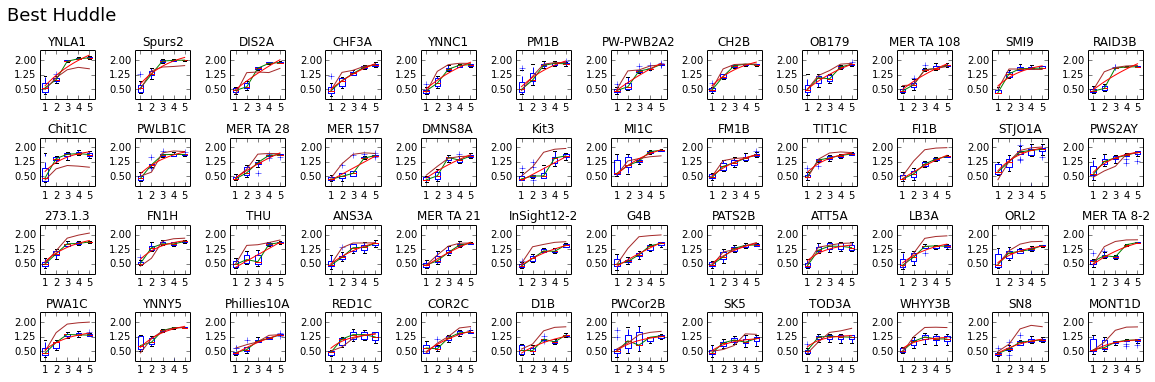

In [17]:
from scipy import optimize

def N(n,a,x) :
    return n*(1-exp(-a*x))

def residuals( p, y, x ) :
    n, a = p
    err = y - N(n,a,x)
    return err

def Neval(x) :
    return N(N0,a,x)

datasetnames = [ 'data_1_1', 'data_1_2', 'data_2_1', 'data_2_2', 'data_3_1', 'data_3_2' ]

# for each bug, choose their biggest increase in OD among the six trials
# as their 'huddle' score
for experiment in ( spacebugs, groundbugs ) :
    for bug in experiment :
        for name in datasetnames :
            medians = map( median, bug[name] )
            huddle = max(medians) - min(medians)
            
            # least squares fit to exponential saturation model
            N0, a = optimize.leastsq(residuals, [1,0.5], args=(array(medians),array([1,2,3,4,5])))[0]
            Hsat = -log(e**(-a)/2.0)/a
            
            # mark bug as alive or dead
            if Hsat > 1.6 and a < 1.5 :
                alive = True
            else :
                alive = False

            if bug['huddle'] < huddle and alive : 
                bug['N0'], bug['alpha'], bug['Hsat'] = N0, a, Hsat
                bug['huddle'] = huddle
                bug['huddle_d'] = name
                bug['alive'] = True

# print the huddle rankings
f = open('BestHuddleRankings.tsv','w')
f.write('\t'.join( ( 'ranking', 'long name', 'sample name', 'gain in OD (space)', 'gain in OD (ground)', 'alive\n') ) )
for n,bug in enumerate(sorted(spacebugs, key=lambda k: k['huddle'], reverse=True)) :
    groundbug = groundbugs[map( lambda k: k['name'], groundbugs ).index(bug['name'])]
    f.write( '\t'.join( ( str(n+1), bug['longname'], bug['name'], str(bug['huddle']), str(groundbug['huddle']), str(bug['alive']) ) ) + '\n' )
    print str(n+1), bug['name'], str(bug['huddle']), str(groundbug['huddle']), bug['alive']
f.close()
 
# plot the top players
fig, ax = plt.subplots( 4, 12, figsize=(16,5))
fig.suptitle( 'Best Huddle', fontsize=18, x=0.05,y=1.05 )
for n,bug in enumerate(sorted(spacebugs, key=lambda k: k['huddle'], reverse=True)) :
    groundbug = groundbugs[map( lambda k: k['name'], groundbugs ).index(bug['name'])]
    subplot(4,12,n+1)
    ylim((0,2.5))
    yticks( linspace( 0.5, 2.0, 3 ) )
    if bug['alive'] :
        title(bug['name'])
        boxplot(bug[bug['huddle_d']])
        plot([1,2,3,4,5],map(median,bug[bug['huddle_d']]), color='green')
        plot([1,2,3,4,5],map(median,groundbug[groundbug['huddle_d']]), color='brown')
        N0, a = bug['N0'], bug['alpha']
        plot(linspace(1,5),Neval(linspace(1,5)),'red')
    else :
        title(bug['name'], alpha=0.2)
        boxplot(bug['data_1_1'])
        plot([1,2,3,4,5],map(median,bug['data_1_1']), color='green')

fig.tight_layout()
savefig( 'BestHuddle.png', format='png', dpi=100 )
savefig( 'BestHuddle.pdf', format='pdf', dpi=100 )

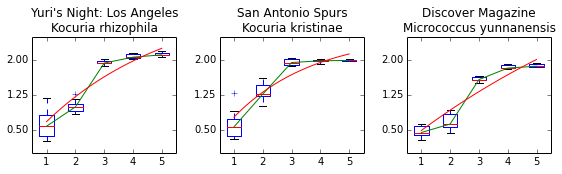

In [18]:
# plot the top players
fig, ax = plt.subplots( 4, 12, figsize=(8,2.5))
#fig.suptitle( 'Best Huddle', fontsize=18, x=0.05,y=1.05 )
for n,bug in enumerate(sorted(spacebugs, key=lambda k: k['huddle'], reverse=True)[:3]) :
    subplot(1,3,n+1)
    ylim((0,2.5))
    yticks( linspace( 0.5, 2.0, 3 ) )
    if bug['alive'] :
        title(bug['longname'] + '\n' + bug['species'])
        boxplot(bug[bug['huddle_d']])
        plot([1,2,3,4,5],map(median,bug[bug['huddle_d']]), color='green')
        N0, a = bug['N0'], bug['alpha']
        plot(linspace(1,5),Neval(linspace(1,5)),'red')
    else :
        title(bug['longname'], alpha=0.2)
        boxplot(bug['data_1_1'])
        plot([1,2,3,4,5],map(median,bug['data_1_1']), color='green')

fig.tight_layout()
savefig( 'BestHuddle_top3.png', format='png', dpi=100 )
savefig( 'BestHuddle_top3.pdf', format='pdf', dpi=100 )

# Best tipoff

1 Chit1C 0.9916 0.5717 True
2 SMI9 0.9633 1.0295 True
3 PWS2AY 0.8961 0.8622 True
4 PWLB1C 0.8804 0.6457 True
5 FN1H 0.8612 0.8248 True
6 TIT1C 0.8488 0.977 True
7 273.1.3 0.8385 0.7987 True
8 PW-PWB2A2 0.8239 0.9501 True
9 LB3A 0.821 0.8448 True
10 RED1C 0.8142 0.7939 True
11 ATT5A 0.806 0.8732 True
12 InSight12-2 0.7615 0.8858 True
13 RAID3B 0.7469 0.9347 True
14 PM1B 0.7377 0.8022 True
15 Spurs2 0.7063 0.9416 True
16 MER 157 0.6994 0.7441 True
17 CH2B 0.6924 1.0287 True
18 TOD3A 0.6888 0.6831 True
19 YNLA1 0.6638 0.6142 True
20 CHF3A 0.6626 0.9201 True
21 OB179 0.6282 0.9961 True
22 D1B 0.6188 0.4784 True
23 ORL2 0.5993 0.7621 True
24 FI1B 0.5872 0.7773 True
25 SN8 0.5781 0.4562 True
26 FM1B 0.5724 0.8126 True
27 DIS2A 0.5722 1.0877 True
28 PWA1C 0.5605 0.9592 True
29 YNNC1 0.5468 1.0836 True
30 PWCor2B 0.5316 0.3128 True
31 SK5 0.5269 0.5301 True
32 STJO1A 0.519 0.9437 True
33 MER TA 108 0.4959 0.7096 True
34 WHYY3B 0.489 0.9726 True
35 MER TA 21 0.4542 0.5216 True
36 ANS3A 0.4513 

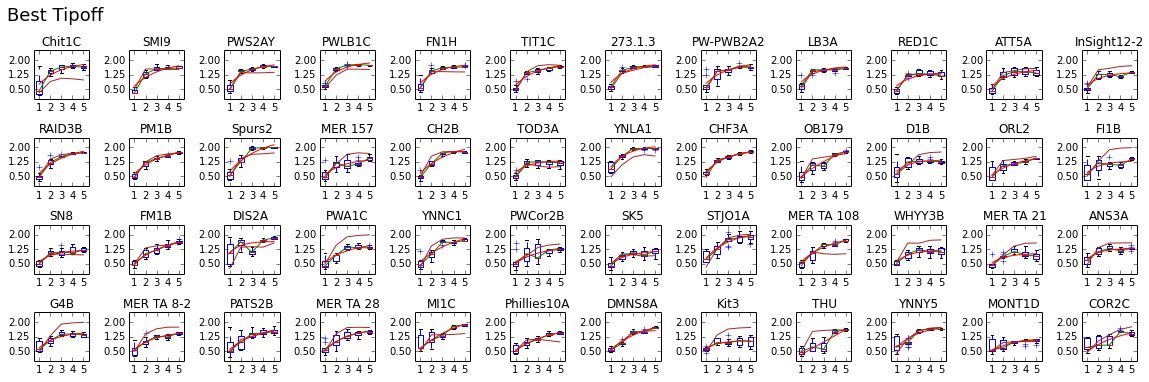

In [19]:
from scipy import optimize

def N(n,a,x) :
    return n*(1-exp(-a*x))

def residuals( p, y, x ) :
    n, a = p
    err = y - N(n,a,x)
    return err

def Neval(x) :
    return N(N0,a,x)

datasetnames = [ 'data_1_1', 'data_1_2', 'data_2_1', 'data_2_2', 'data_3_1', 'data_3_2' ]

# for each bug, choose their biggest first-day increase in OD among the six trials
# as their 'tipoff' score
for experiment in ( spacebugs, groundbugs ) :
    for bug in experiment :
        for name in datasetnames :
            medians = map( median, bug[name] )
            tipoff = medians[1] - medians[0]
            
            # least squares fit to exponential saturation model
            N0, a = optimize.leastsq(residuals, [1,0.5], args=(array(medians),array([1,2,3,4,5])))[0]
            Hsat = -log(e**(-a)/2.0)/a
            
            # mark bug as alive or dead
            if Hsat > 1.6 and a < 1.5 :
                alive = True
            else :
                alive = False
        
            if bug['tipoff'] < tipoff and alive : 
                bug['N0'], bug['alpha'], bug['Hsat'] = N0, a, Hsat
                bug['tipoff'] = tipoff
                bug['tipoff_d'] = name
                bug['alive'] = True

# print the tipoff rankings
f = open('BestTipoffRankings.tsv','w')
f.write('\t'.join( ( 'ranking', 'long name', 'sample name', 'gain in OD (space)', 'gain in OD (ground)', 'alive\n') ) )
for n,bug in enumerate(sorted(spacebugs, key=lambda k: k['tipoff'], reverse=True)) :
    groundbug = groundbugs[map( lambda k: k['name'], groundbugs ).index(bug['name'])]
    f.write( '\t'.join( ( str(n+1), bug['longname'], bug['name'], str(bug['tipoff']), str(groundbug['tipoff']), str(bug['alive']) ) ) + '\n' )
    print str(n+1), bug['name'], str(bug['tipoff']), str(groundbug['tipoff']), bug['alive']
f.close()
 
# plot the top players
fig, ax = plt.subplots( 4, 12, figsize=(16,5))
fig.suptitle( 'Best Tipoff', fontsize=18, x=0.05,y=1.05 )
for n,bug in enumerate(sorted(spacebugs, key=lambda k: k['tipoff'], reverse=True)) :
    groundbug = groundbugs[map( lambda k: k['name'], groundbugs ).index(bug['name'])]
    subplot(4,12,n+1)
    ylim((0,2.5))
    yticks( linspace( 0.5, 2.0, 3 ) )
    if bug['alive'] :
        title(bug['name'])
        boxplot(bug[bug['tipoff_d']])
        plot([1,2,3,4,5],map(median,bug[bug['tipoff_d']]), color='green')
        plot([1,2,3,4,5],map(median,groundbug[groundbug['tipoff_d']]), color='brown')
        N0, a = bug['N0'], bug['alpha']
        plot(linspace(1,5),Neval(linspace(1,5)),'red')
    else :
        title(bug['name'], alpha=0.2)
        boxplot(bug['data_1_1'])
        plot([1,2,3,4,5],map(median,bug['data_1_1']), color='green')

fig.tight_layout()
savefig( 'BestTipoff.png', format='png', dpi=100 )
savefig( 'BestTipoff.pdf', format='pdf', dpi=100 )

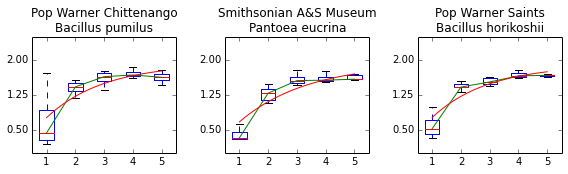

In [20]:
# plot the top players

fig, ax = plt.subplots( 4, 12, figsize=(8,2.5))
#fig.suptitle( 'Best Tipoff', fontsize=18, x=0.05,y=1.05 )
for n,bug in enumerate(sorted(spacebugs, key=lambda k: k['tipoff'], reverse=True)[:3]) :
    subplot(1,3,n+1)
    ylim((0,2.5))
    yticks( linspace( 0.5, 2.0, 3 ) )
    
    #fulltitle = r'' + bug['longname'].replace('&','\&') + '\n {\em ' + bug['species'] + '}'
    if bug['alive'] :
        title(bug['longname'] + '\n' + bug['species'])
        boxplot(bug[bug['tipoff_d']])
        plot([1,2,3,4,5],map(median,bug[bug['tipoff_d']]), color='green')
        N0, a = bug['N0'], bug['alpha']
        plot(linspace(1,5),Neval(linspace(1,5)),'red')
    else :
        title(fulltitle, alpha=0.2)
        boxplot(bug['data_1_1'])
        plot([1,2,3,4,5],map(median,bug['data_1_1']), color='green')

fig.tight_layout()
savefig( 'BestTipoff_top3.png', format='png', dpi=100 )
savefig( 'BestTipoff_top3.pdf', format='pdf', dpi=100 )


#Best sprint

1 RAID3B 1.0518 0.9347 True
2 Chit1C 0.9916 0.5717 True
3 MER 157 0.9726 0.7441 True
4 SMI9 0.9633 1.0295 True
5 DIS2A 0.958 1.0877 True
6 DMNS8A 0.9508 0.9437 True
7 YNLA1 0.9451 0.6142 True
8 Spurs2 0.9324 0.9416 True
9 Kit3 0.9223 0.8683 True
10 THU 0.8973 1.0273 True
11 PWS2AY 0.8961 0.8622 True
12 PWLB1C 0.8804 0.9924 True
13 FN1H 0.8612 0.8811 True
14 TIT1C 0.8488 0.977 True
15 273.1.3 0.8385 0.7987 True
16 FI1B 0.8255 0.7773 True
17 PW-PWB2A2 0.8239 0.9501 True
18 LB3A 0.821 0.8448 True
19 RED1C 0.8142 0.7939 True
20 ATT5A 0.806 0.8732 True
21 MER TA 108 0.7728 0.7679 True
22 InSight12-2 0.7615 0.8858 True
23 CHF3A 0.7595 0.9201 True
24 PM1B 0.7561 0.8022 True
25 STJO1A 0.7514 0.9437 True
26 MI1C 0.7277 0.8573 True
27 YNNC1 0.7184 1.0836 True
28 COR2C 0.6937 0.5813 True
29 CH2B 0.6924 1.0287 True
30 TOD3A 0.6888 0.733 True
31 MER TA 28 0.6664 0.8927 True
32 OB179 0.6282 0.9961 True
33 MER TA 8-2 0.6277 0.8944 True
34 YNNY5 0.6264 0.7384 True
35 PATS2B 0.6204 0.7486 True
36 D1B 0

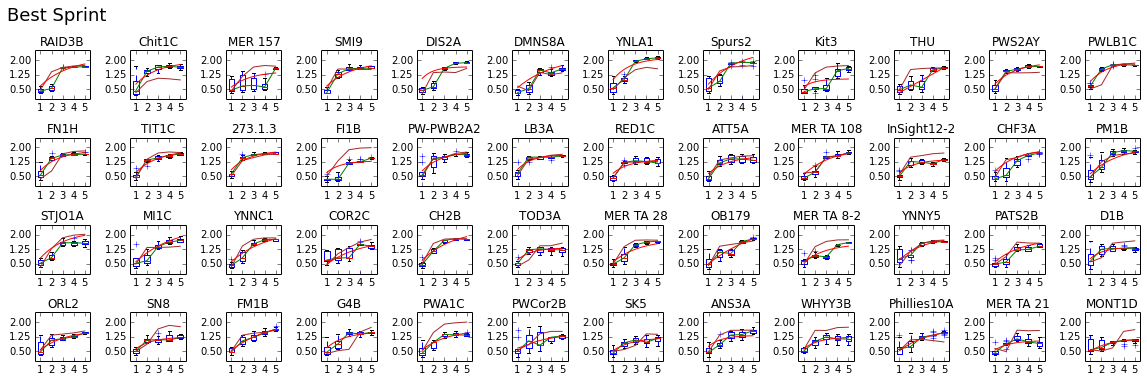

In [22]:
from scipy import optimize

def N(n,a,x) :
    return n*(1-exp(-a*x))

def residuals( p, y, x ) :
    n, a = p
    err = y - N(n,a,x)
    return err

def Neval(x) :
    return N(N0,a,x)

datasetnames = [ 'data_1_1', 'data_1_2', 'data_2_1', 'data_2_2', 'data_3_1', 'data_3_2' ]

# for each bug, choose their biggest first-day increase in OD among the six trials
# as their 'tipoff' score
for experiment in ( spacebugs, groundbugs ) :
    for bug in experiment :
        for name in datasetnames :
            medians = map( median, bug[name] )
            
            # least squares fit to exponential saturation model
            N0, a = optimize.leastsq(residuals, [1,0.5], args=(array(medians),array([1,2,3,4,5])))[0]
            Hsat = -log(e**(-a)/2.0)/a
            
            sprint = max( [ ( medians[1] - medians[0] ),
                            ( medians[2] - medians[1] ),
                            ( medians[3] - medians[2] ),
                            ( medians[4] - medians[3] ) ] )
            
            # mark bug as alive or dead
            if Hsat > 1.6 and a < 1.5 :
                alive = True
            else :
                alive = False
        
            if bug['sprint'] < sprint and alive : 
                bug['N0'], bug['alpha'], bug['Hsat'] = N0, a, Hsat
                bug['sprint'] = sprint
                bug['sprint_d'] = name
                bug['alive'] = True

# print the sprint rankings
f = open('BestSprintRankings.tsv','w')
f.write('\t'.join( ( 'ranking', 'long name', 'sample name', 'gain in OD (space)', 'gain in OD (ground)', 'alive\n') ) )
for n,bug in enumerate(sorted(spacebugs, key=lambda k: k['sprint'], reverse=True)) :
    groundbug = groundbugs[map( lambda k: k['name'], groundbugs ).index(bug['name'])]
    f.write( '\t'.join( ( str(n+1), bug['longname'], bug['name'], str(bug['sprint']), str(groundbug['sprint']), str(bug['alive']) ) ) + '\n' )
    print str(n+1), bug['name'], str(bug['sprint']), str(groundbug['sprint']), bug['alive']
f.close()
 
# plot the top players
fig, ax = plt.subplots( 4, 12, figsize=(16,5))
fig.suptitle( 'Best Sprint', fontsize=18, x=0.05,y=1.05 )
for n,bug in enumerate(sorted(spacebugs, key=lambda k: k['sprint'], reverse=True)) :
    groundbug = groundbugs[map( lambda k: k['name'], groundbugs ).index(bug['name'])]
    subplot(4,12,n+1)
    ylim((0,2.5))
    yticks( linspace( 0.5, 2.0, 3 ) )
    if bug['alive'] :
        title(bug['name'])
        boxplot(bug[bug['sprint_d']])
        plot([1,2,3,4,5],map(median,bug[bug['sprint_d']]), color='green')
        plot([1,2,3,4,5],map(median,groundbug[groundbug['sprint_d']]), color='brown')
        N0, a = bug['N0'], bug['alpha']
        plot(linspace(1,5),Neval(linspace(1,5)),'red')
    else :
        title(bug['name'], alpha=0.2)
        boxplot(bug['data_1_1'])
        plot([1,2,3,4,5],map(median,bug['data_1_1']), color='green')

fig.tight_layout()
savefig( 'BestSprint.png', format='png', dpi=100 )
savefig( 'BestSprint.pdf', format='pdf', dpi=100 )

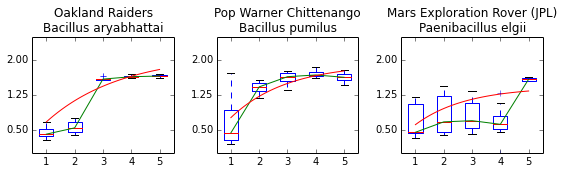

In [23]:
# plot the top players

fig, ax = plt.subplots( 4, 12, figsize=(8,2.5))
#fig.suptitle( 'Best Tipoff', fontsize=18, x=0.05,y=1.05 )
for n,bug in enumerate(sorted(spacebugs, key=lambda k: k['sprint'], reverse=True)[:3]) :
    subplot(1,3,n+1)
    ylim((0,2.5))
    yticks( linspace( 0.5, 2.0, 3 ) )
    
    #fulltitle = r'' + bug['longname'].replace('&','\&') + '\n {\em ' + bug['species'] + '}'
    if bug['alive'] :
        title(bug['longname'] + '\n' + bug['species'])
        boxplot(bug[bug['sprint_d']])
        plot([1,2,3,4,5],map(median,bug[bug['sprint_d']]), color='green')
        N0, a = bug['N0'], bug['alpha']
        plot(linspace(1,5),Neval(linspace(1,5)),'red')
    else :
        title(fulltitle, alpha=0.2)
        boxplot(bug['data_1_1'])
        plot([1,2,3,4,5],map(median,bug['data_1_1']), color='green')

fig.tight_layout()
savefig( 'BestSprint_top3.png', format='png', dpi=100 )
savefig( 'BestSprint_top3.pdf', format='pdf', dpi=100 )

# Space vs. Ground

In [39]:
from scipy import optimize

def N(n,a,x) :
    return n*(1-numpy.exp(-a*x))

def residuals( p, y, x ) :
    n, a = p
    err = y - N(n,a,x)
    return err

def Neval(x) :
    return N(N0,a,x)

datasetnames = [ 'data_1_1', 'data_1_2', 'data_2_1', 'data_2_2', 'data_3_1', 'data_3_2' ]

# for each bug, choose their biggest first-day increase in OD among the six trials
# as their 'tipoff' score
for experiment in ( spacebugs, groundbugs ) :
    for bug in experiment :
        bug['alldata'] = map( lambda x: x[0]+x[1]+x[2]+x[3]+x[4]+x[5], 
                            zip(  bug['data_1_1'], \
                                  bug['data_1_2'], \
                                  bug['data_2_1'], \
                                  bug['data_2_2'], \
                                  bug['data_3_1'], \
                                  bug['data_3_2']))
        medians = map( numpy.median, bug['alldata'] )
        
        # least squares fit to exponential saturation model
        N0, a = optimize.leastsq(residuals, [1,0.5], args=(numpy.array(medians),numpy.array([1,2,3,4,5])))[0]
        Hsat = -numpy.log(numpy.e**(-a)/2.0)/a
                        
# print the rankings
f = open('Space_vs_Ground.tsv','w')
f.write('\t'.join(( "n", "short name", "long name", "space 96h OD", "space 96h OD std", "ground 96h OD", "ground 96h OD std", "alive"))
 )
print '\t'.join(( "n", "short name", "long name", "space 96h OD", "space 96h OD std", "ground 96h OD", "ground 96h OD std", "alive"))
for n,bug in enumerate(sorted(spacebugs, key=lambda k: k['sprint'], reverse=True)) :
    groundbug = groundbugs[map( lambda k: k['name'], groundbugs ).index(bug['name'])]
    space96OD     = mean( groundbug['alldata'][-1])
    space96ODstd  = std(  bug['alldata'][-1])
    ground96OD    = mean( groundbug['alldata'][-1])
    ground96ODstd = std(  groundbug['alldata'][-1])
    f.write( '\t'.join((str(n+1), bug['name'], bug['longname'], str(space96OD), str(space96ODstd), str(ground96OD), str(ground96ODstd), str(bug['alive'], '\n')) ) )
    print '\t'.join((str(n+1), bug['name'], bug['longname'], str(space96OD), str(space96ODstd), str(ground96OD), str(ground96ODstd), str(bug['alive'])))
f.close()
 
# plot the top players
fig, ax = plt.subplots( 4, 12, figsize=(16,5))
fig.suptitle( 'Space vs. Ground', fontsize=18, x=0.05,y=1.05 )
for n,bug in enumerate(sorted(spacebugs, key=lambda k: k['sprint'], reverse=True)) :
    subplot(4,12,n+1)
    ylim((0,2.5))
    yticks( linspace( 0.5, 2.0, 3 ) )
    groundbug = groundbugs[n]
    if bug['alive'] :
        title(bug['name'])
        boxplot(bug['alldata'])
        plot([1,2,3,4,5],map(median,bug['alldata']), color='green')
        plot([1,2,3,4,5],map(median,groundbug['alldata']), color='brown')
        N0, a = bug['N0'], bug['alpha']
        plot(linspace(1,5),Neval(linspace(1,5)),'red')
    else :
        title(bug['name'], alpha=0.2)
        boxplot(bug['data_1_1'])
        plot([1,2,3,4,5],map(median,bug['alldata']), color='green')

fig.tight_layout()
savefig( 'Space_vs_Ground.png', format='png', dpi=100 )
savefig( 'Space_vs_Ground.pdf', format='pdf', dpi=100 )

n	short name	long name	space 96h OD	space 96h OD std	ground 96h OD	ground 96h OD std	alive


TypeError: str() takes at most 1 argument (2 given)

In [25]:
%matplotlib inline
from scipy import optimize
from pylab import * 

def N(n,a,x) :
    return n*(1-numpy.exp(-a*x))

def residuals( p, y, x ) :
    n, a = p
    err = y - N(n,a,x)
    return err

def Neval(x) :
    return N(N0,a,x)

datasetnames = [ 'data_1_1', 'data_1_2', 'data_2_1', 'data_2_2', 'data_3_1', 'data_3_2' ]

# for each bug, choose their biggest first-day increase in OD among the six trials
# as their 'tipoff' score
for experiment in ( spacebugs, groundbugs ) :
    for bug in experiment :
        bug['alldata'] = map( lambda x: x[0]+x[1]+x[2]+x[3]+x[4]+x[5], 
                            zip(  bug['data_1_1'], \
                                  bug['data_1_2'], \
                                  bug['data_2_1'], \
                                  bug['data_2_2'], \
                                  bug['data_3_1'], \
                                  bug['data_3_2']))
        medians = map( numpy.median, bug['alldata'] )
        
        # least squares fit to exponential saturation model
        N0, a = optimize.leastsq(residuals, [1,0.5], args=(numpy.array(medians),numpy.array([1,2,3,4,5])))[0]
        Hsat = -numpy.log(numpy.e**(-a)/2.0)/a
                        
# print the rankings
#f = open('BestSprintRankings.tsv','w')
#f.write('\t'.join( ( 'ranking', 'long name', 'sample name', 'gain in OD (space)', 'gain in OD (ground)', 'alive\n') ) )
#for n,bug in enumerate(sorted(spacebugs, key=lambda k: k['sprint'], reverse=True)) :
#    groundbug = groundbugs[map( lambda k: k['name'], groundbugs ).index(bug['name'])]
#    f.write( '\t'.join( ( str(n+1), bug['longname'], bug['name'], str(bug['sprint']), str(groundbug['sprint']), str(bug['alive']) ) ) + '\n' )
#    print str(n+1), bug['name'], str(bug['sprint']), str(groundbug['sprint']), bug['alive']
#f.close()
 
# plot the top players
#fig, ax = plt.subplots( 4, 12, figsize=(32,8))
#fig.suptitle( 'Space vs. Ground', fontsize=18, x=0.05,y=1.05 )
for n,bug in enumerate(sorted(spacebugs, key=lambda k: k['sprint'], reverse=True)) :
    #subplot(4,12,n+1)
    ylim((0,2.5))
    yticks( linspace( 0.5, 2.0, 3 ) )
    groundbug = groundbugs[n]
    if bug['alive'] :
        title(bug['longname'])
        #boxplot(bug['alldata'])
        #plot([1,2,3,4,5],map(numpy.median,bug['alldata']), color='green')
        errorbar( [1,2,3,4,5],map(numpy.median,bug['alldata']), yerr=map(numpy.std,bug['alldata']), color='green' )
        errorbar([1,2,3,4,5],map(numpy.median,groundbug['alldata']), yerr=map(numpy.std,groundbug['alldata']), color='brown', linestyle='--')
        xticks([1,2,3,4,5],[0,24,48,72,96])
        xlim([0.7, 5.3])
    else :
        title(bug['name'], alpha=0.2)
        boxplot(bug['data_1_1'])
        plot([1,2,3,4,5],map(numpy.median,bug['alldata']), color='green')
    fig.tight_layout()
    savefig( 'Space_v_Ground/' + bug['name'] + '.png', format='png', dpi=100 )
    savefig( 'Space_v_Ground/' + bug['name'] + '.pdf', format='pdf', dpi=100 )
    close()

In [31]:
std(bug['alldata'][-1])

0.23474408124529617